In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from bnr_ml.nnet import layers
from bnr_ml.objectdetect import yolo
from bnr_ml.nnet.updates import momentum
import theano
from theano import tensor as T
from collections import OrderedDict
from tqdm import tqdm

import lasagne
import lasagne.layers as layers

import pickle as pk

import pdb

In [3]:
def gen_num_objs(max_obj):
    return int(1 + max_obj * np.random.rand())

In [4]:
def gen_classes(num_obj, num_class):
    return np.random.randint(num_class, size=(num_obj,))

In [5]:
def gen_circle(shape):
#     pdb.set_trace()
    row, col = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    row, col = row.astype(np.float64), col.astype(np.float64)
    row = (row - row.shape[1] / 2) / (row.shape[1] / 2)
    col = (col - col.shape[0] / 2) / (col.shape[0] / 2)
    
    
    im = np.zeros(shape + (1,))
    for i in range(im.shape[2]):
        in_ellipse = (row**2 + col**2) < 1
#         im[:,:,i][in_ellipse] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))[in_ellipse]
        im[:,:,i][in_ellipse] = np.ones(shape)[in_ellipse]
    im[im < 0] = 0.
    im[im >= 1] = 1.
    return im

In [6]:
def gen_rect(shape):
    im = np.zeros(shape + (3,))
    for i in range(3):
        im[:,:,i] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))
    im[im < 0] = 0.
    im[im > 1] = 1.
    return im

In [7]:
def gen_triangle(shape):
    row, col = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    row, col = row.astype(np.float64), col.astype(np.float64)
    row = row / row.shape[1]
    col = col / col.shape[0]
    
    
    im = np.zeros(shape + (1,))
    if np.random.rand() < .5:
        in_triangle = row + col < 1
    else:
        in_triangle = row + col > 1
    for i in range(im.shape[2]):
        im[:,:,i][in_triangle] = np.ones(shape)[in_triangle]
#         im[:,:,i][in_triangle] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))[in_triangle]
    im[im < 0] = 0.
    im[im >= 1] = 1.
    return im

In [8]:
def gen_pos_shape(min_shape, im_shape):
    shape = (
        int(min_shape[0] + (im_shape[0] - min_shape[0]) * np.random.rand()),
        int(min_shape[1] + (im_shape[1] - min_shape[1]) * np.random.rand())
    )
    pos = (
        int((im_shape[0] - shape[0]) * np.random.rand()),
        int((im_shape[1] - shape[1]) * np.random.rand())
    )
    return shape, pos

In [9]:
def gen_scene(max_obj, num_class, min_shape, im_shape):
    num_obj = gen_num_objs(max_obj)
    classes = gen_classes(num_obj, num_class)
    im = np.random.gamma(.4) * np.random.randn(*(im_shape + (1,)))
    im[im < 0] = 0.
    im[im > 1] = 1.
    y = np.zeros((4 + num_class,))
    
    for cls in classes:
        shape, pos = gen_pos_shape(min_shape, im_shape)
        y[:4] = pos + shape
        y[-num_class + cls] += 1.
        if cls == 0:
            shp = gen_circle(shape)
        elif cls == 1:
            shp = gen_triangle(shape)
        elif cls == 2:
            shp = gen_triangle(shape)
        else:
            pass
        im[pos[0]:pos[0]+shape[0],pos[1]:pos[1]+shape[1],:] += shp
    return im / np.max(im), y

In [10]:
def gen_dataset(size, shape):
    X, y = np.zeros((size,1) + shape), np.zeros((size,4+2))
    for i in range(size):
        dat = gen_scene(1, 2, (20, 20), shape)
        X[i], y[i] = dat[0].swapaxes(2,1).swapaxes(1,0), dat[1]
    return X, y

In [394]:
X,y = gen_dataset(1000, (100,100))

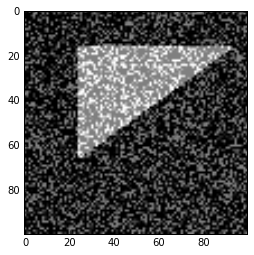

In [395]:
N = np.int_(X.shape[0] * np.random.rand())
plt.imshow(X[N,0], 'gray')
plt.show()

In [396]:
input = T.tensor4('input')

In [397]:
l1 = layers.InputLayer((None,1,100,100), input_var=input)
l2 = layers.Conv2DLayer(
    l1,
    8,
    (3,3)
)
l3 = layers.Conv2DLayer(
    l2,
    8,
    (3,3)
)
l4 = layers.Pool2DLayer(
    l3,
    (3,3)
)
l5 = layers.Conv2DLayer(
    l4,
    16,
    (3,3)
)
l6 = layers.Conv2DLayer(
    l5,
    16,
    (3,3)
)
l7 = layers.Pool2DLayer(
    l6,
    (3,3)
)

le1 = layers.Conv2DLayer(
    l7,
    16,
    (3,3)
)
le2 = layers.Conv2DLayer(
    le1,
    16,
    (3,3)
)
le3 = layers.Pool2DLayer(
    le2,
    (2,2)
)

l8 = layers.DenseLayer(
    layers.dropout(le3, p=.0),
    100
)
l9 = layers.DenseLayer(
    layers.dropout(l8, p=.0),
    100,
)
l10 = layers.DenseLayer(
    layers.dropout(l9, p=.0),
    2,
    nonlinearity=lasagne.nonlinearities.softmax
)

In [398]:
with open('../weights/weights.pkl', 'rb') as f:
    weights = pk.load(f)

In [399]:
layers.set_all_param_values(l10, weights)

In [400]:
olayer = layers.DenseLayer(
    layers.dropout(l8, p=.0),
    2 * 2 * (10 + 2)
)

In [401]:
net = {}
net['input'] = l1
net['l2'] = l2
net['l3'] = l3
net['l4'] = l4
net['l5'] = l5
net['l6'] = l6
net['l7'] = l7
net['le1'] = le1
net['le2'] = le2
net['le3'] = le3
net['l8'] = l8
net['output'] = olayer

In [402]:
reload(layers)
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.pyc'>

In [403]:
yl = yolo.YoloObjectDetector(net, (None,1,100,100), 2, (2,2), 2)

In [438]:
train_loss, test_loss = yl.train(
    X,
    y,
    lr=1e-4,
    momentum=0.5,
    train_test_split=0.95,
    epochs=100,
    batch_size=100
)

Getting cost...
Compiling...


  0%|          | 0/100 [00:00<?, ?it/s]

Beginning training...


  1%|          | 1/100 [00:27<44:36, 27.03s/it]

Epoch 0
------
Train Loss: 0.0380, Test Loss: 0.0371


  2%|▏         | 2/100 [00:54<44:08, 27.03s/it]

Epoch 1
------
Train Loss: 0.0373, Test Loss: 0.0369


  3%|▎         | 3/100 [01:21<43:45, 27.06s/it]

Epoch 2
------
Train Loss: 0.0368, Test Loss: 0.0367


  4%|▍         | 4/100 [01:48<43:17, 27.06s/it]

Epoch 3
------
Train Loss: 0.0508, Test Loss: 0.0367


  5%|▌         | 5/100 [02:15<42:52, 27.08s/it]

Epoch 4
------
Train Loss: 0.0367, Test Loss: 0.0368


  6%|▌         | 6/100 [02:42<42:26, 27.09s/it]

Epoch 5
------
Train Loss: 0.0364, Test Loss: 0.0366


  7%|▋         | 7/100 [03:09<41:58, 27.09s/it]

Epoch 6
------
Train Loss: 0.0364, Test Loss: 0.0365


  8%|▊         | 8/100 [03:36<41:39, 27.17s/it]

Epoch 7
------
Train Loss: 0.0364, Test Loss: 0.0364


  9%|▉         | 9/100 [04:04<41:10, 27.15s/it]

Epoch 8
------
Train Loss: 0.0359, Test Loss: 0.0363


 10%|█         | 10/100 [04:31<40:43, 27.15s/it]

Epoch 9
------
Train Loss: 0.0358, Test Loss: 0.0363


 11%|█         | 11/100 [04:58<40:20, 27.20s/it]

Epoch 10
------
Train Loss: 0.0364, Test Loss: 0.0360


 12%|█▏        | 12/100 [05:25<39:51, 27.17s/it]

Epoch 11
------
Train Loss: 0.0364, Test Loss: 0.0359


 13%|█▎        | 13/100 [05:52<39:19, 27.12s/it]

Epoch 12
------
Train Loss: 0.0359, Test Loss: 0.0358


 14%|█▍        | 14/100 [06:20<39:01, 27.23s/it]

Epoch 13
------
Train Loss: 0.0360, Test Loss: 0.0357


 15%|█▌        | 15/100 [06:47<38:36, 27.26s/it]

Epoch 14
------
Train Loss: 0.0357, Test Loss: 0.0357


 16%|█▌        | 16/100 [07:14<38:05, 27.21s/it]

Epoch 15
------
Train Loss: 0.0357, Test Loss: 0.0356


 17%|█▋        | 17/100 [07:41<37:41, 27.25s/it]

Epoch 16
------
Train Loss: 0.0354, Test Loss: 0.0352


 18%|█▊        | 18/100 [08:09<37:13, 27.24s/it]

Epoch 17
------
Train Loss: 0.0354, Test Loss: 0.0352


 19%|█▉        | 19/100 [08:36<36:43, 27.20s/it]

Epoch 18
------
Train Loss: 0.0353, Test Loss: 0.0353


 20%|██        | 20/100 [09:03<36:15, 27.19s/it]

Epoch 19
------
Train Loss: 0.0350, Test Loss: 0.0351


 21%|██        | 21/100 [09:30<35:44, 27.14s/it]

Epoch 20
------
Train Loss: 0.0350, Test Loss: 0.0349


 22%|██▏       | 22/100 [09:57<35:19, 27.17s/it]

Epoch 21
------
Train Loss: 0.0350, Test Loss: 0.0348


 23%|██▎       | 23/100 [10:24<34:46, 27.09s/it]

Epoch 22
------
Train Loss: 0.0349, Test Loss: 0.0348


 24%|██▍       | 24/100 [10:51<34:20, 27.11s/it]

Epoch 23
------
Train Loss: 0.0345, Test Loss: 0.0348


 25%|██▌       | 25/100 [11:18<33:57, 27.17s/it]

Epoch 24
------
Train Loss: 0.0347, Test Loss: 0.0348


 26%|██▌       | 26/100 [11:46<33:32, 27.20s/it]

Epoch 25
------
Train Loss: 0.0349, Test Loss: 0.0345


 27%|██▋       | 27/100 [12:13<33:02, 27.16s/it]

Epoch 26
------
Train Loss: 0.0344, Test Loss: 0.0346


 28%|██▊       | 28/100 [12:40<32:32, 27.11s/it]

Epoch 27
------
Train Loss: 0.0342, Test Loss: 0.0343


 29%|██▉       | 29/100 [13:07<32:02, 27.08s/it]

Epoch 28
------
Train Loss: 0.0341, Test Loss: 0.0343


 30%|███       | 30/100 [13:34<31:34, 27.06s/it]

Epoch 29
------
Train Loss: 0.0341, Test Loss: 0.0342


 31%|███       | 31/100 [14:01<31:10, 27.11s/it]

Epoch 30
------
Train Loss: 0.0345, Test Loss: 0.0343


 32%|███▏      | 32/100 [14:28<30:40, 27.07s/it]

Epoch 31
------
Train Loss: 0.0343, Test Loss: 0.0341


 33%|███▎      | 33/100 [14:56<30:23, 27.22s/it]

Epoch 32
------
Train Loss: 0.0341, Test Loss: 0.0340


 34%|███▍      | 34/100 [15:23<29:52, 27.16s/it]

Epoch 33
------
Train Loss: 0.0340, Test Loss: 0.0339


 35%|███▌      | 35/100 [15:50<29:28, 27.21s/it]

Epoch 34
------
Train Loss: 0.0339, Test Loss: 0.0338


 36%|███▌      | 36/100 [16:17<28:59, 27.18s/it]

Epoch 35
------
Train Loss: 0.0342, Test Loss: 0.0339


 37%|███▋      | 37/100 [16:44<28:31, 27.17s/it]

Epoch 36
------
Train Loss: 0.0340, Test Loss: 0.0339


 38%|███▊      | 38/100 [17:11<28:02, 27.14s/it]

Epoch 37
------
Train Loss: 0.0337, Test Loss: 0.0338


 39%|███▉      | 39/100 [17:38<27:37, 27.17s/it]

Epoch 38
------
Train Loss: 0.0336, Test Loss: 0.0338


 40%|████      | 40/100 [18:05<27:06, 27.12s/it]

Epoch 39
------
Train Loss: 0.0338, Test Loss: 0.0335


 41%|████      | 41/100 [18:33<26:42, 27.16s/it]

Epoch 40
------
Train Loss: 0.0333, Test Loss: 0.0334


 42%|████▏     | 42/100 [19:00<26:15, 27.16s/it]

Epoch 41
------
Train Loss: 0.0337, Test Loss: 0.0335


 43%|████▎     | 43/100 [19:27<25:40, 27.03s/it]

Epoch 42
------
Train Loss: 0.0338, Test Loss: 0.0340


 44%|████▍     | 44/100 [19:54<25:23, 27.20s/it]

Epoch 43
------
Train Loss: 0.0338, Test Loss: 0.0334


 45%|████▌     | 45/100 [20:21<24:54, 27.18s/it]

Epoch 44
------
Train Loss: 0.0335, Test Loss: 0.0332


 46%|████▌     | 46/100 [20:48<24:25, 27.14s/it]

Epoch 45
------
Train Loss: 0.0332, Test Loss: 0.0331


 47%|████▋     | 47/100 [21:16<24:02, 27.22s/it]

Epoch 46
------
Train Loss: 0.0334, Test Loss: 0.0331


 48%|████▊     | 48/100 [21:43<23:35, 27.22s/it]

Epoch 47
------
Train Loss: 0.0330, Test Loss: 0.0332


 49%|████▉     | 49/100 [22:10<23:06, 27.19s/it]

Epoch 48
------
Train Loss: 0.0329, Test Loss: 0.0335


 50%|█████     | 50/100 [22:37<22:37, 27.15s/it]

Epoch 49
------
Train Loss: 0.0337, Test Loss: 0.0331


 51%|█████     | 51/100 [23:04<22:08, 27.11s/it]

Epoch 50
------
Train Loss: 0.0332, Test Loss: 0.0330


 52%|█████▏    | 52/100 [23:31<21:42, 27.13s/it]

Epoch 51
------
Train Loss: 0.0330, Test Loss: 0.0332


 53%|█████▎    | 53/100 [23:58<21:12, 27.08s/it]

Epoch 52
------
Train Loss: 0.0331, Test Loss: 0.0332


 54%|█████▍    | 54/100 [24:26<20:59, 27.38s/it]

Epoch 53
------
Train Loss: 0.0333, Test Loss: 0.0330


 55%|█████▌    | 55/100 [24:54<20:29, 27.32s/it]

Epoch 54
------
Train Loss: 0.0333, Test Loss: 0.0329


 56%|█████▌    | 56/100 [25:21<19:59, 27.27s/it]

Epoch 55
------
Train Loss: 0.0332, Test Loss: 0.0329


 57%|█████▋    | 57/100 [25:48<19:30, 27.21s/it]

Epoch 56
------
Train Loss: 0.0327, Test Loss: 0.0331


 58%|█████▊    | 58/100 [26:15<19:02, 27.21s/it]

Epoch 57
------
Train Loss: 0.0335, Test Loss: 0.0328


 59%|█████▉    | 59/100 [26:42<18:32, 27.14s/it]

Epoch 58
------
Train Loss: 0.0330, Test Loss: 0.0328


 60%|██████    | 60/100 [27:09<18:02, 27.07s/it]

Epoch 59
------
Train Loss: 0.0334, Test Loss: 0.0330


KeyboardInterrupt: 

In [439]:
pred_fn = theano.function([yl.input], yl.output)

In [440]:
tmp = pred_fn(X[:200])

(array([123,  50,  80,  87]), array([  9.99928474e-01,   7.15258394e-05]), 0.72568877160128475)
[ 23.  20.  48.  52.]


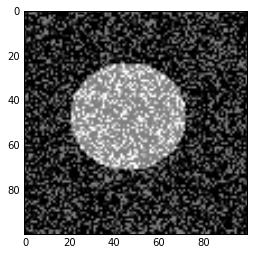

In [479]:
N = np.int_(200 * np.random.rand())
plt.imshow(X[N,0], 'gray')
print find_best_coords(tmp[N], (100,100))
print y[N,:4]

In [469]:
def find_best_coords(output, shape):
    idx = np.argmax(output[[4,9],:,:])
    coord = np.unravel_index(idx, (2,2,2))
    best = np.copy(output[coord[0] * 5:coord[0]*5 + 4, coord[1], coord[2]])
    best[0] += float(coord[1]) / 2
    best[1] += float(coord[2]) / 2
    best[[0,2]] *= shape[0]
    best[[1,3]] *= shape[1]
    best = np.int_(np.round(best))
    return best, output[-2:,coord[1],coord[2]], output[[4,9],:,:][coord[0],coord[1],coord[2]]

In [427]:
print find_best_coords(tmp[N], (100,100))

(array([  0, 258,  50,  89]), (1, 0), array([ 0.00714653,  0.99285347]))


In [350]:
np.argmax(tmp[0,[4,9],:,:])

4

In [298]:
np.unravel_index(4, (2,2,2))

(1, 0, 0)

In [300]:
tmp[0,[4,9],:,:][1,0,0]

0.82384296387747824

In [98]:
act_fn = theano.function([input], layers.get_output(le3))

In [99]:
tmp = act_fn(X[:20])

In [104]:
tmp.max()

12.478808450101068

In [125]:
Xtest, ytest = gen_dataset(100, (100,100))

In [159]:
preds = pred_fn(Xtest)

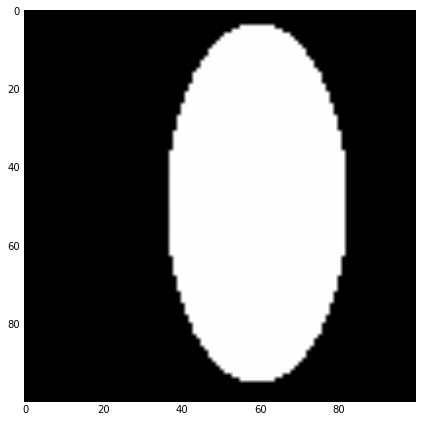

[ 0.5         0.5         0.5         0.5         0.5         0.55200492
  0.5         0.85603257  0.5         0.75187069  0.46587127  0.53412873]
[ 0.5         0.5         0.74491826  0.5         0.85834509  0.5         0.5
  0.5         0.5         0.5         0.49313074  0.50686926]
[ 0.5         0.5         0.5         0.56942442  0.5         0.5         0.5
  0.5         0.5         0.5         0.47401481  0.52598519]
[ 0.5         0.5         0.98718083  0.5417662   0.50982821  0.5         0.5
  1.          0.5         0.5         0.4769725   0.5230275 ]


In [163]:
N = np.int_(Xtest.shape[0] * np.random.rand())
fig = plt.figure(figsize=(7,7))
plt.imshow(Xtest[N,0], 'gray')
plt.show()

for i in range(2):
    for j in range(2):
        print preds[N,:,i,j]

In [132]:
ytest[N]

array([ 12.,  63.,  63.,  26.,   1.,   0.])